In [1]:
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import wordnet, stopwords
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import squarify
import matplotlib.pyplot as plt
import re
import gensim
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_size(SIZE = 20):
    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)

In [3]:
data = pd.read_csv("data/mooc_tags.txt",delimiter="\t")
data.columns = ['text']
data.head()

,text
0,area
1,living things
2,plants: growth and changes
3,animals: growth and change
4,structures


In [4]:
data.describe()

,text
count,2096
unique,2094
top,efl
freq,2


There are 2096 tags in the database

# 1) Exploratory data analysis

First, depend on the dataset and on the purpose, we decide what to be removed.
Need to see some samples in the dataset and try to detect some special things to be removed.
For instant, we remove urls, hashtag, @, numbers, punctuations.

In [5]:
urls_re = r'http\S+' #urls
ht_re = r'#\S+'      #hashtags
at_re = r'@\S+'      #@
nb_re = " \d+"       #numbers

punctuations = ["/","(",")","\\","|", ":",",",";",".","?", "!", "[", "]", "{","}"]

def standardize_text(df, text_field):
    new_text = []
    for text in df[text_field]:
        
        text = text.replace("\\n"," ").replace("\n", " ").replace("-"," ").replace("_"," ").replace('amp'," ").replace('co', " ")
        
        for x in punctuations:
            text = text.replace(x , " ")
            
        text = re.sub(urls_re , " ", text)
        text = re.sub(ht_re   , " ", text)
        text = re.sub(at_re   , " ", text)
        text = re.sub(nb_re   , " ", text)
        
        text = text.replace("http"," ")
        
        new_text.append(text.lower())
    
    df['standardized_' + text_field] = new_text
    return df

data = standardize_text(data, "text")
data.head()

,text,standardized_text
0,area,area
1,living things,living things
2,plants: growth and changes,plants growth and changes
3,animals: growth and change,animals growth and change
4,structures,structures


In [6]:
def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

Secondly, we need to choose `indexing terms` for our TFIDF matrix. Step by step:
* Tokenization: splitting the text into words (actually a NLP issue, think about `credit card`...)
* Stopwords removing: term explicitely to be excluded from indexing (the, a, be, this, to, or...). What happened if we have a text `to be or not to be` ?
* Lemmatization: process of reducing words. For instant: eats, eating, ate, eaten => eat. It helps reduces index size / increases information value of each indexing term.

In [7]:
tokenizer = RegexpTokenizer(r'\w+')
def processing(sentence):
    
    "Tokenization"
    sentence = tokenizer.tokenize(sentence)
    
    "Stopwords removing"
    stop = stopwords.words('english')
    sentence = [x for x in sentence if x not in stop ]
    
    "Lemmatization"
    lemmatiser = WordNetLemmatizer()
    tokens_pos = pos_tag(sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    
    sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    
    return ' '.join(sentence)

In [8]:
def processing_text(df, text_field):
    new_text = []
    for text in df[text_field]:
        new_text.append(processing(text))
    df['processed_text'] = new_text
    return df

In [9]:
data = processing_text(data, 'standardized_text')
data.head()

,text,standardized_text,processed_text
0,area,area,area
1,living things,living things,live thing
2,plants: growth and changes,plants growth and changes,plant growth change
3,animals: growth and change,animals growth and change,animal growth change
4,structures,structures,structure


In [10]:
data['length'] = data['processed_text'].apply(lambda row : len(row.split()))
data.head()

,text,standardized_text,processed_text,length
0,area,area,area,1
1,living things,living things,live thing,2
2,plants: growth and changes,plants growth and changes,plant growth change,3
3,animals: growth and change,animals growth and change,animal growth change,3
4,structures,structures,structure,1


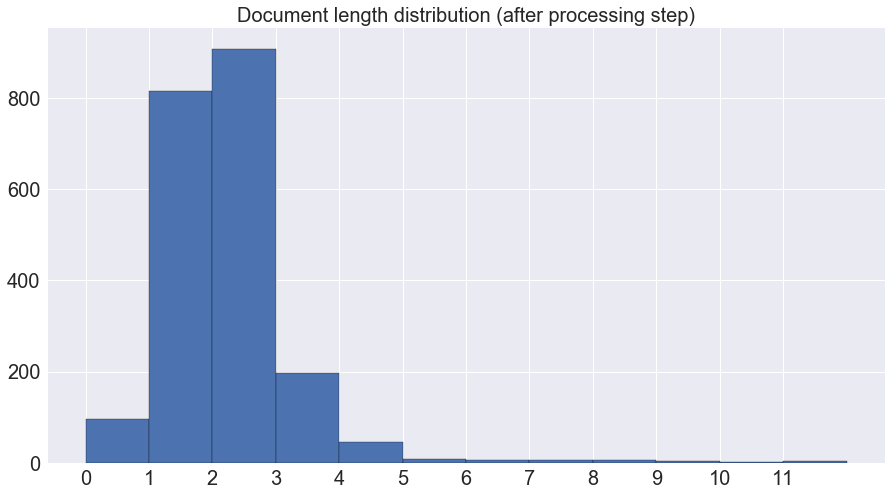

In [11]:
set_size()
plt.subplots(figsize=(15,8))
data['length'].hist(bins=data['length'].max(),edgecolor='black')
plt.xticks(list(range(0,data['length'].max())))
plt.title('Document length distribution (after processing step)')
plt.show()

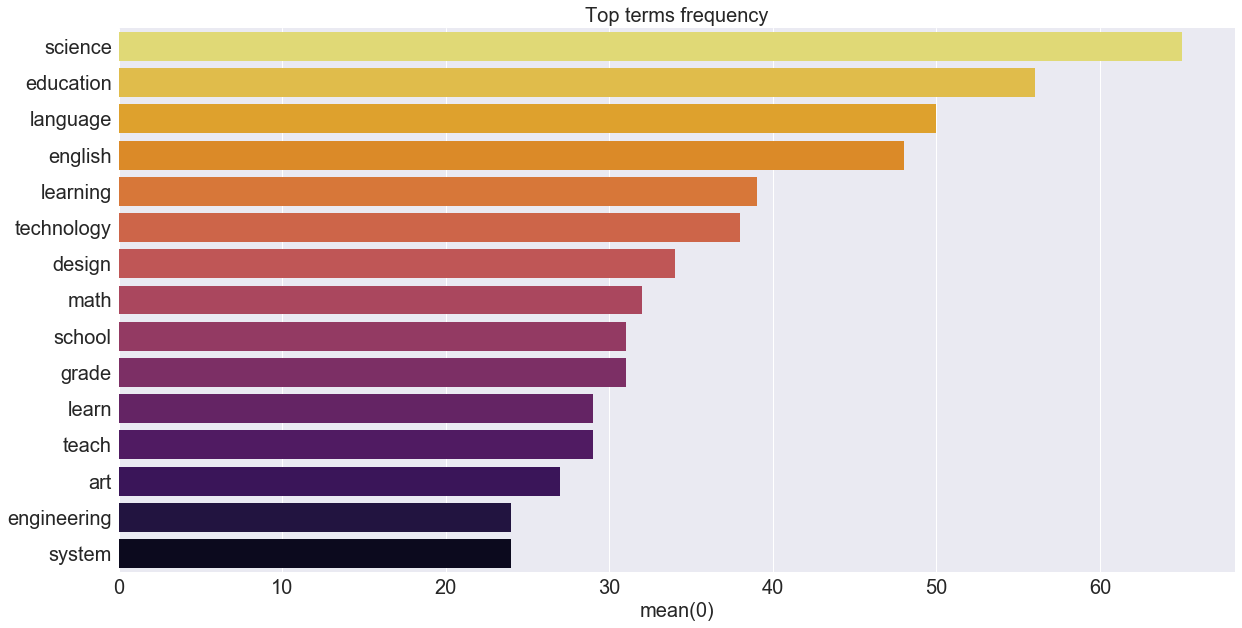

In [12]:
set_size()

terms = []

for text in data['processed_text']:
    for term in text.split():
        terms.append(term)
        
plt1 = pd.Series(terms).value_counts().sort_values(ascending=False)[:15].to_frame()
sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',15))
plt.title('Top terms frequency')
fig=plt.gcf()
fig.set_size_inches(20,10)
plt.show()

# 2) Word2Vec on the dataset + PCA

Try to train a word2vec model using our dataset then project into 2 principle components

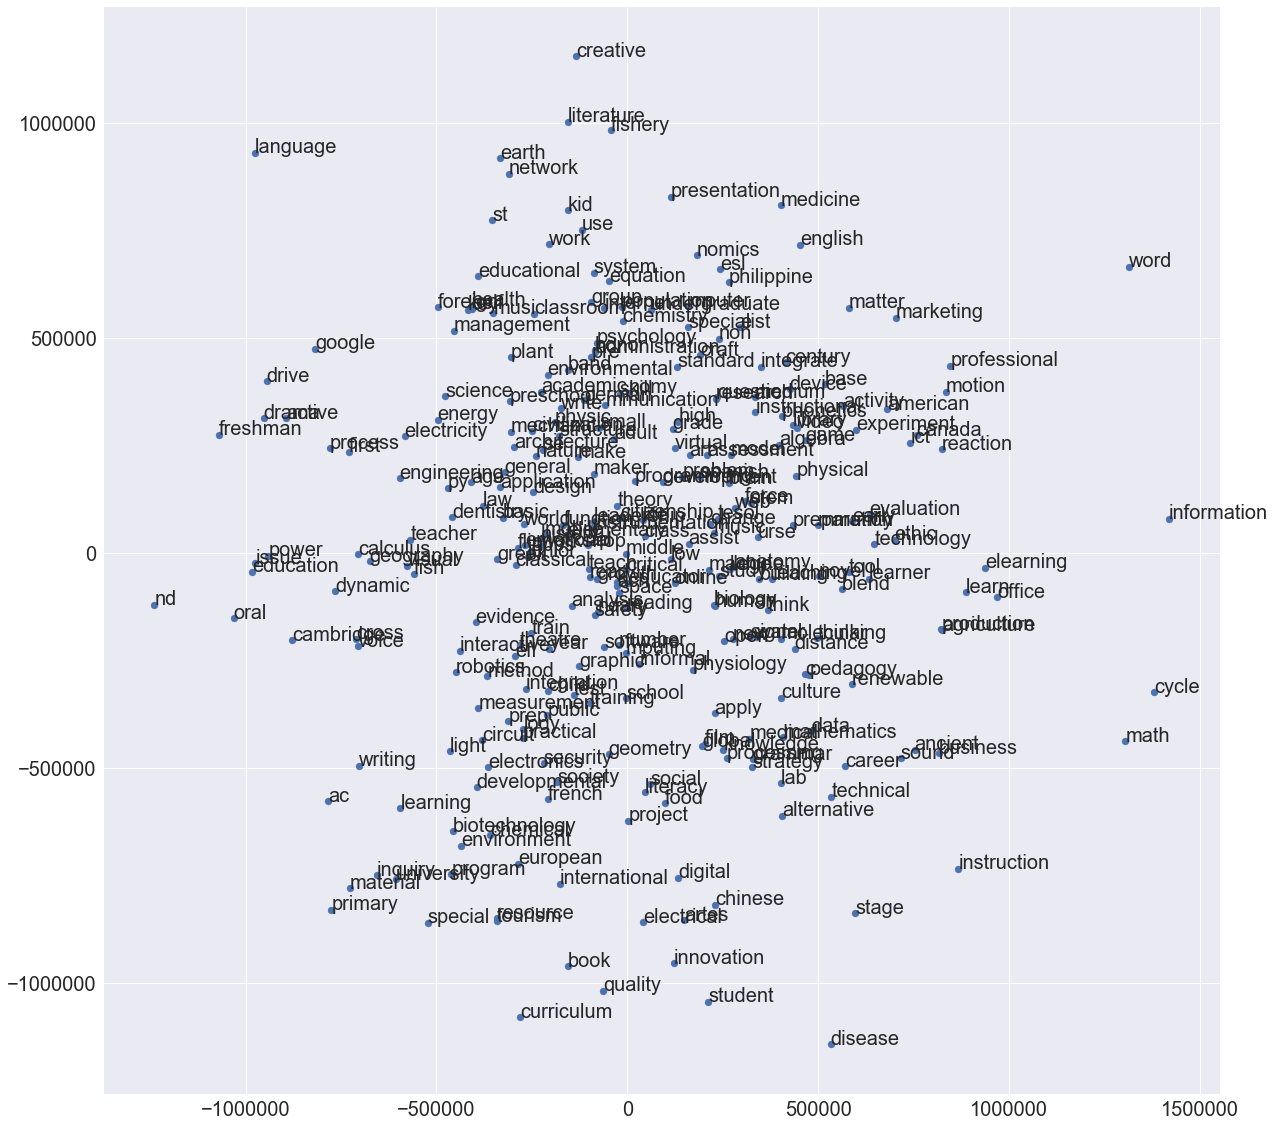

In [13]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

sentences = [x.split() for x in np.array(data['processed_text'])]

model = Word2Vec(sentences, min_count=3)

X = model[model.wv.vocab]
X *= 100000000
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.figure(figsize=(20,20))
set_size()
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

This method seems to be fail, we cannot cluster the tags

# 3) Word2Vec using a pre-train model of Google

In [15]:
word2vec_path = "/Users/Cescnghia/Documents/dataset/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [37]:
word2vec['king'].shape

(300,)

Each word is depocomsed into 300 dimensions

In [20]:
word2vec.most_similar(positive=['queen', 'men'], negative=['king'], topn=1)

[('women', 0.7216065526008606)]

Queen - King + Man = Women

### 3.1 Topic modeling with LDA and NMF (Non-negative Matrix Factorization) algorithm

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [22]:
"Create TF-IDF matrix for both algos"

vocab_size = 500


" Non-negative Matrix Factorization is able to use tf-idf "


tfidf_vectorizer = TfidfVectorizer(max_features=vocab_size)
tfidf = tfidf_vectorizer.fit_transform(data['processed_text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()



" LDA can only use raw term counts for LDA because it is a probabilistic graphical model"

tf_vectorizer = CountVectorizer(max_features=vocab_size)
tf = tf_vectorizer.fit_transform(data['processed_text'])
tf_feature_names = tf_vectorizer.get_feature_names()

In [23]:
tf.shape

(2096, 500)

In [24]:
"Build Model"

no_topics = 20

"NMF"
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

"LDA"
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


In [25]:
def plot_topic(row, vocabulary, topics, nbTopics, n_terms, nbColsPlot):
    MAGIC_NUMBER = 50
    fontsize_init = MAGIC_NUMBER
    fig = plt.figure(figsize=(15, 7))
    for topic in range(row, min(row + nbColsPlot, nbTopics)):

        plt.subplot(1, nbColsPlot, topic%nbColsPlot + 1)
        plt.ylim(0, n_terms + .5)
        plt.xticks([]) 
        plt.yticks([])
        plt.title('Topic #{}'.format(topic+1), fontsize=30)
        top_index = topics[topic].argsort()[:-n_terms - 1:-1]
        scores = topics[topic][top_index]
        max_topic_score = max(scores)
        for ind in range(len(top_index)):
            font_size = fontsize_init*scores[ind]/max_topic_score
            font_size = min(font_size, MAGIC_NUMBER)
            font_size = max(font_size, 15)
            #if (all(ord(char) < 128 for char in vocabulary[ind])):
            plt.text(0.05, n_terms-ind-0.5, vocabulary[top_index[ind]], fontsize=font_size) 
    plt.tight_layout()
    plt.show()

def plot_topics(model, vocab, nbTopics, n_terms=10, nbColsPlot=4):
    vocabulary = vocab
    topics = model.components_
    for row in range(0, nbTopics, nbColsPlot):
        plot_topic(row, vocabulary, topics, nbTopics, n_terms, nbColsPlot)


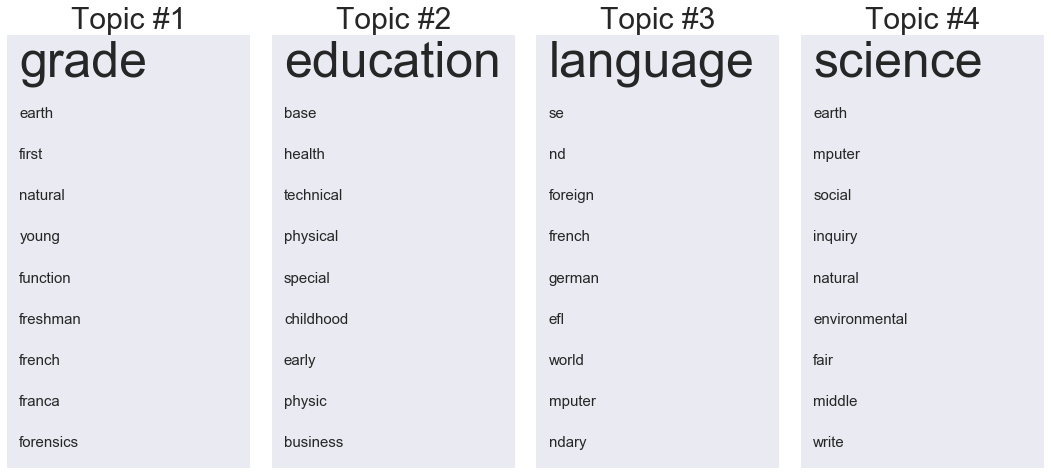

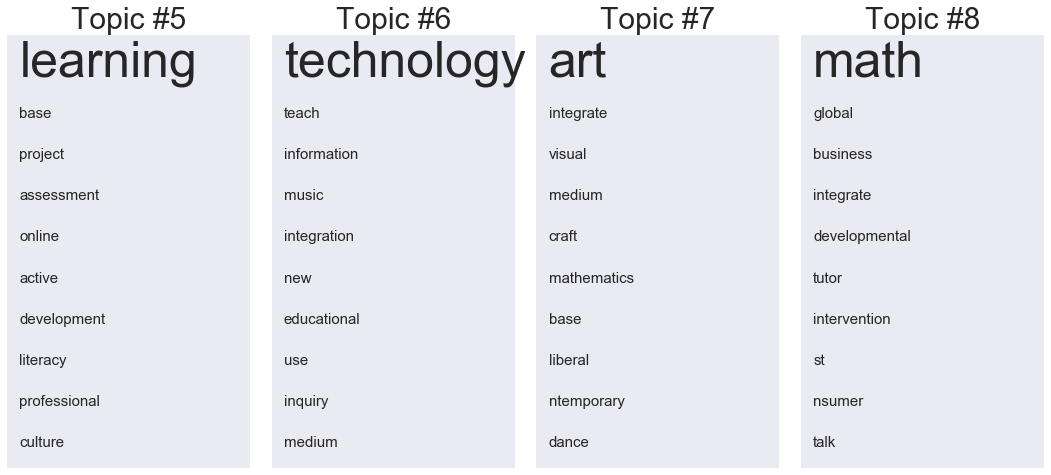

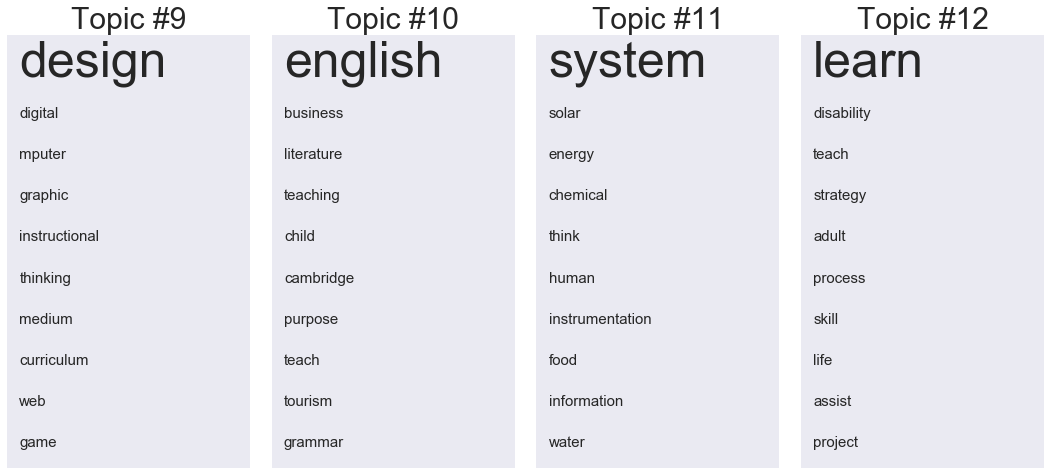

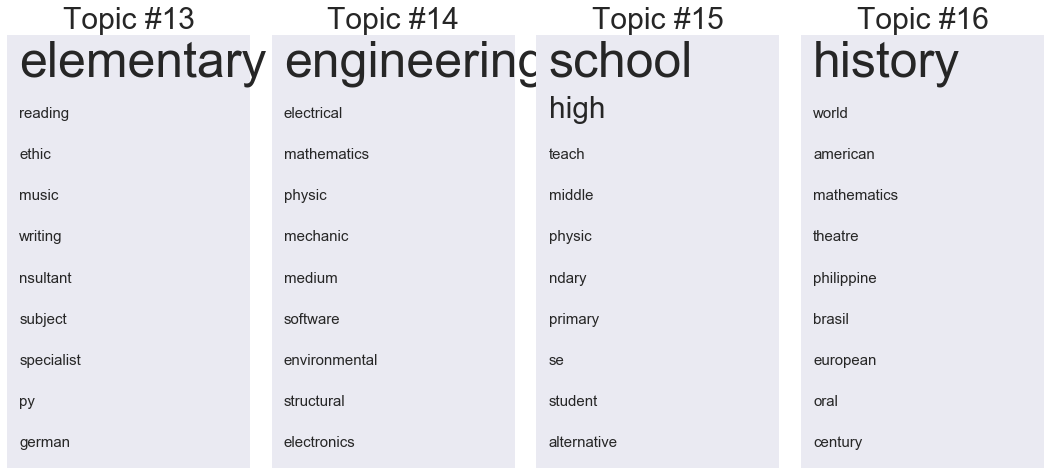

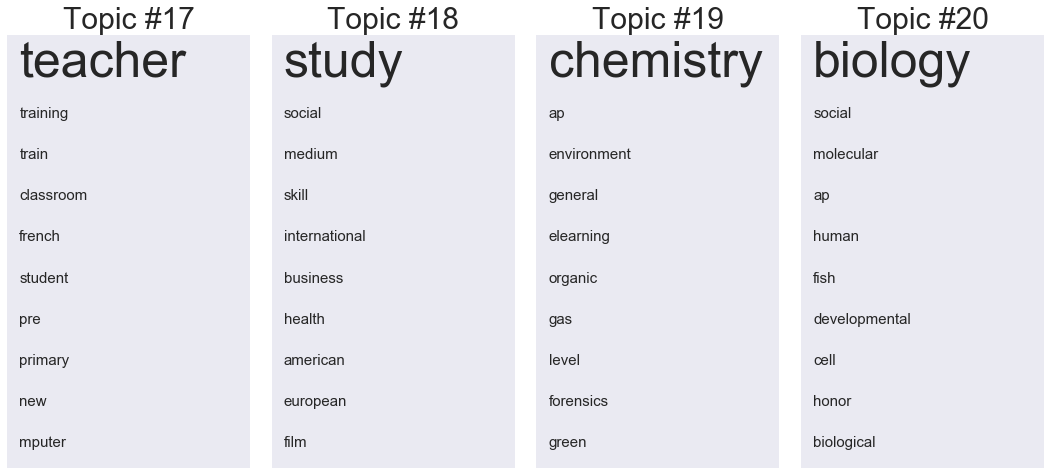

In [26]:
"NMF results"

plot_topics(nmf, tfidf_feature_names, no_topics)

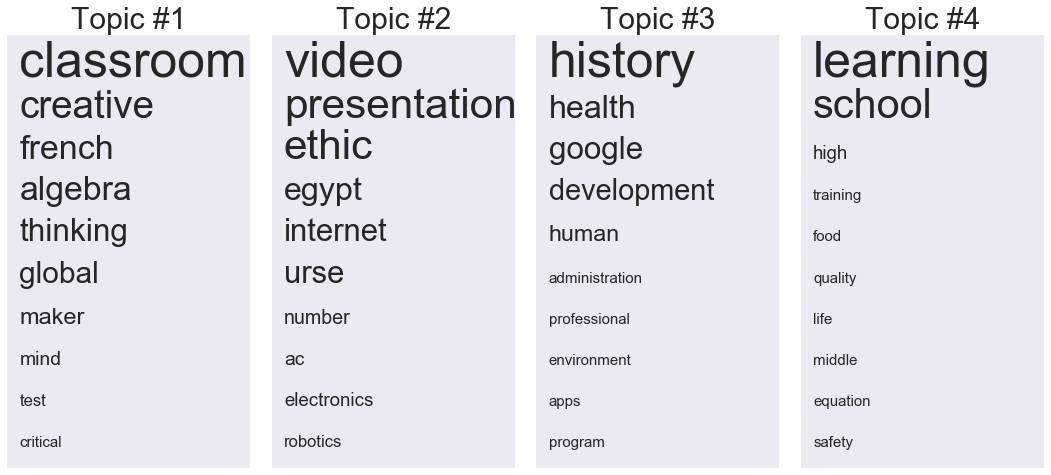

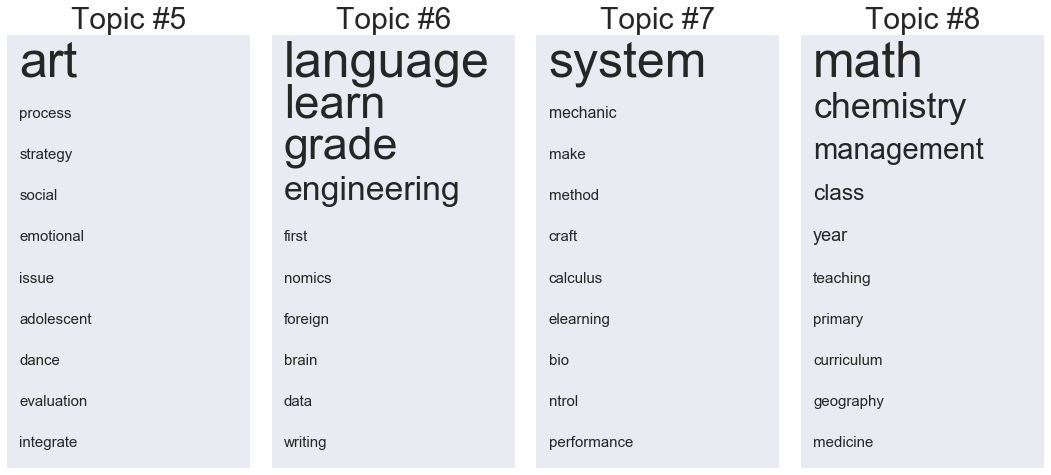

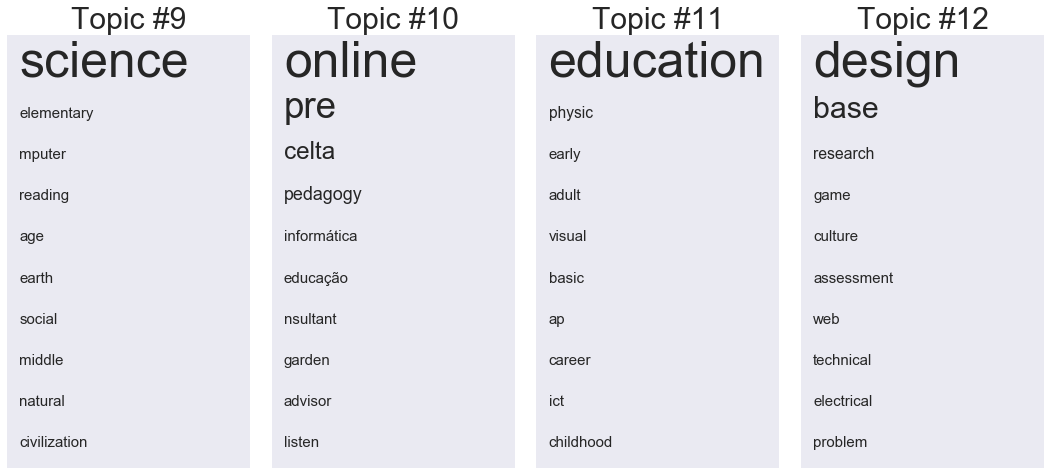

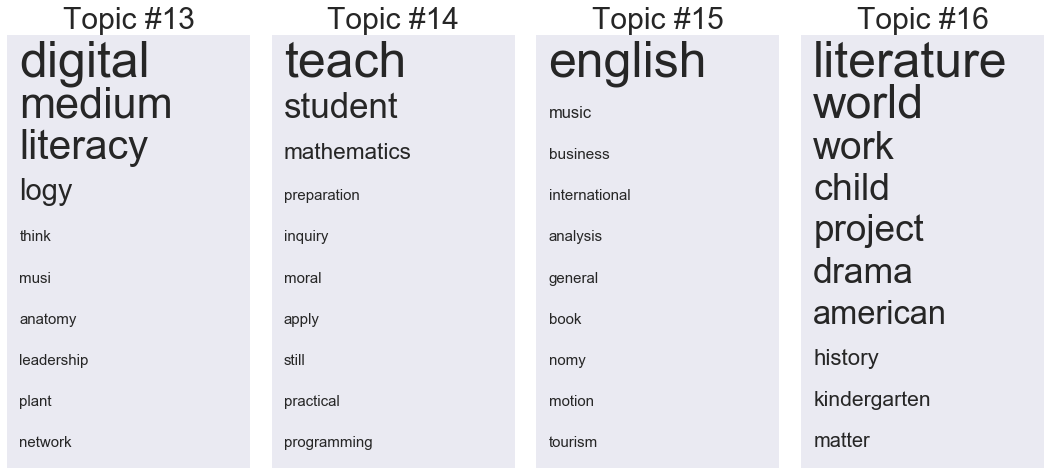

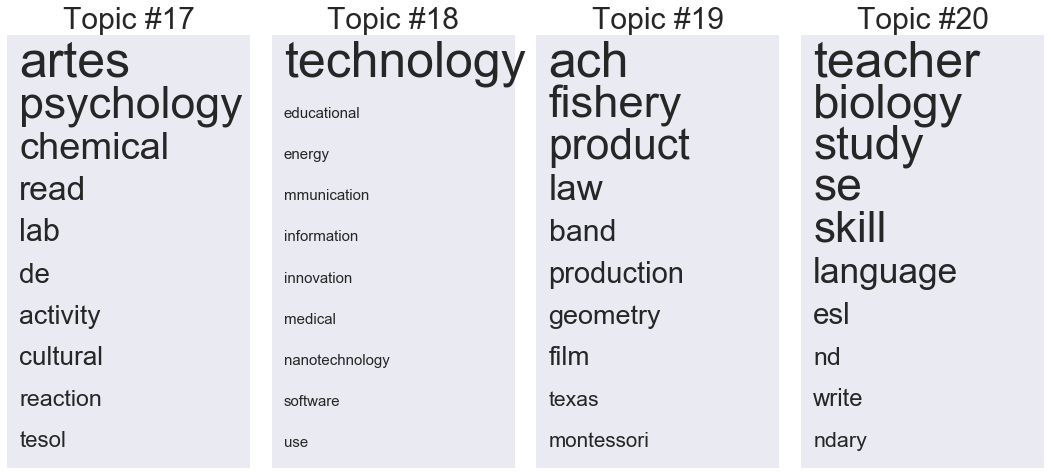

In [27]:
"LDA results"

plot_topics(lda, tf_feature_names, no_topics)

These two algorithms are also fail to detect topics since the documents are too short.

In [50]:
tfidf.shape

(2096, 1471)

In [24]:
word2vec.wv.most_similar(positive=['woman', 'king'], negative=['man'],restrict_vocab = 100000, topn=1)

[('queen', 0.7118192315101624)]

In [25]:
word2vec.wv.most_similar(positive=['woman'], topn=1)

[('man', 0.7664012312889099)]

In [26]:
word2vec.wv.most_similar(positive=['english','french', 'language'], topn=3)

[('English', 0.7001354694366455),
 ('spanish', 0.6610627174377441),
 ('langauge', 0.6367570161819458)]

In [27]:
word2vec.wv.most_similar(positive=['vietnamese', 'language'], topn=3)

[('langauge', 0.6591478586196899),
 ('phonetic_transcription', 0.5940282344818115),
 ('Roman_alphabets', 0.5884756445884705)]

In [28]:
word2vec.wv.most_similar(positive=['french', 'language'], topn=3)

[('english', 0.6654443740844727),
 ('langauge', 0.6344116926193237),
 ('English', 0.6264394521713257)]

In [29]:
word2vec.wv.most_similar(['home', 'language'], topn=3)

[('langauge', 0.5208531618118286),
 ('English', 0.4878714382648468),
 ('named_Eduardo_Caraveo', 0.4781302213668823)]

### 3.2) What if all topics are known ?

In [28]:
responses = ['football', 'learn', 'boyfriend', 'girlfriend', 'basketball','tennis', 'swimming', 'love', 'physic']
topics = ['sport', 'education', 'love', 'other', 'economic', 'politics', 'food', 'environment']

In [29]:
def max_similarity(tuples):
    tuples = [item for sublist in tuples for item in sublist]
    max_index = -3
    max_value = -3
    for index, value in enumerate(tuples):
        if (value[1] > max_value):
            max_index = index
            max_value = value[1]
            
    return max_index

In [30]:
restrict_vocab = 1000000

def cluster(responses, topics, word2vec):
    cluster = {}
    for topic in topics:
        cluster[topic] = []
    
    for response in responses:
        if (response in word2vec):
            similarity = [word2vec.most_similar([response, topic], topn = 1,restrict_vocab=restrict_vocab) for topic in topics]
            max_index = max_similarity(similarity)
            temp = cluster[topics[max_index]]
            temp.append(response)
            cluster[topics[max_index]] = temp
        else:
            temp = cluster['other']
            temp.append(response)
            cluster['other'] = temp
    
    return cluster

In [31]:
start_time = time.time()
results = cluster(responses, topics, word2vec)
print("--- %s seconds ---" % (time.time() - start_time))

--- 5.013657093048096 seconds ---


In [32]:
results

{'economic': [],
 'education': ['learn', 'physic'],
 'environment': [],
 'food': [],
 'love': ['boyfriend', 'girlfriend', 'love'],
 'other': [],
 'politics': [],
 'sport': ['football', 'basketball', 'tennis', 'swimming']}

### 3.3) Word2Vec + K means

The idea is take all 1-gram tags, transform it into vector and cluster it.

In [40]:
one_gram = data[data['length'] == 1]
print('There are',len(one_gram),'1-gram tags.')

There are 815 1-gram tags.


For assigning a vector to word using pre-train model of google, we will have a problem with words(in our dataset) that are not contained in the word2vec model of google. For instance, I will take only the tags that are in the word2vec model of google.

In [41]:
one_gram['meaningful_word2vec'] = one_gram['processed_text'].apply(lambda x : x in word2vec)
one_gram.head()

,text,standardized_text,processed_text,length,meaningful_word2vec
0,area,area,area,1,True
4,structures,structures,structure,1,True
6,soil,soil,soil,1,True
7,pe,pe,pe,1,True
8,anathomy,anathomy,anathomy,1,False


In [42]:
one_gram = one_gram[one_gram['meaningful_word2vec']==True]

In [44]:
def word2vector(word):
    return word2vec[word]

In [46]:
one_gram['word2vec'] = one_gram['processed_text'].apply(word2vector)
one_gram.head()

,text,standardized_text,processed_text,length,meaningful_word2vec,word2vec
0,area,area,area,1,True,"[-0.072265625, 0.052490234, 0.053955078, -0.05..."
4,structures,structures,structure,1,True,"[0.032226562, 0.022338867, -0.059814453, 0.021..."
6,soil,soil,soil,1,True,"[-0.14941406, 0.484375, 0.34765625, -0.0126342..."
7,pe,pe,pe,1,True,"[0.0018234253, 0.22363281, 0.10644531, 0.23925..."
12,css,css,cs,1,True,"[-0.16992188, 0.16699219, 0.265625, -0.0061035..."


In [48]:
from sklearn.cluster import KMeans

In [49]:
words = np.array(one_gram['processed_text'])

In [50]:
X = []
for x in one_gram['word2vec']:
    X.append(list(x))

In [58]:
"Run k-means algorithm"
k = 40

kmeans = KMeans(n_clusters=k, random_state=2).fit(X)
labels = kmeans.labels_

In [59]:
dict_cluster = {}

for index, label in enumerate(labels):
    if label in dict_cluster:
        temp = dict_cluster[label]
        temp.append(index)
        dict_cluster[label] = temp
    else:
        dict_cluster[label] = [index]

In [62]:
for key in range(k):
    indexes = dict_cluster[key]
    print('Cluster number: ',key)
    for index in indexes:
        print('---------',words[index])

Cluster number:  0
--------- twitter
--------- facebook
Cluster number:  1
--------- administrator
--------- primary
--------- principal
--------- general
Cluster number:  2
--------- asia
--------- islam
--------- europe
--------- egypt
Cluster number:  3
--------- pe
--------- cs
--------- gt
--------- tb
--------- std
--------- jk
--------- sk
--------- ng
--------- l
--------- fe
--------- eal
--------- ding
--------- c
--------- ding
--------- ell
--------- c
--------- ged
--------- texas
--------- p
--------- u
--------- li
--------- ele
Cluster number:  4
--------- bilingual
Cluster number:  5
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
--------- grade
Cluster number:  6
--------- instrument
--------- artifact
--------- piano
Cluster number:  7
--------- science
--------- physiology
--------- electrochemistry
--------